**First clone the github repository** https://github.com/prabhat-123/Attendance_System_Using_Face_Recognition


In [12]:
!git clone https://github.com/prabhat-123/Attendance_System_Using_Face_Recognition

fatal: destination path 'Attendance_System_Using_Face_Recognition' already exists and is not an empty directory.


**Install virtural environment**

In [13]:
!python -m pip install --user virtualenv

In [14]:
!pwd

/content/Attendance_System_Using_Face_Recognition


**Change the working directory to inside the main project folder globally (*i.e. use %cd not !cd*) and install the virtual environment inside that directory** 

In [15]:
%cd /content/Attendance_System_Using_Face_Recognition

/content/Attendance_System_Using_Face_Recognition


In [16]:
# %python -m venv venv     #not working
# venv\Scripts\activate

**Install following dependencies**

In [17]:
!pip install sklearn
!pip install matplotlib
!pip install opencv-contrib-python
!pip install requests
!pip install imutils
!pip install tqdm
# !pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 3.1MB/s 


In [18]:
!pwd

/content/Attendance_System_Using_Face_Recognition


**After installation change the working directory to models/retinaface**

In [19]:
%cd models/retinaface/

/content/Attendance_System_Using_Face_Recognition/models/retinaface


**Running box_utils.py**

In [20]:
import torch
import numpy as np


def point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax


def center_size(boxes):
    """ Convert prior_boxes to (cx, cy, w, h)
    representation for comparison to center-size form ground truth data.
    Args:
        boxes: (tensor) point_form boxes
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, 2:] + boxes[:, :2])/2,  # cx, cy
                     boxes[:, 2:] - boxes[:, :2], 1)  # w, h


def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def matrix_iou(a, b):
    """
    return iou of a and b, numpy version for data augenmentation
    """
    lt = np.maximum(a[:, np.newaxis, :2], b[:, :2])
    rb = np.minimum(a[:, np.newaxis, 2:], b[:, 2:])

    area_i = np.prod(rb - lt, axis=2) * (lt < rb).all(axis=2)
    area_a = np.prod(a[:, 2:] - a[:, :2], axis=1)
    area_b = np.prod(b[:, 2:] - b[:, :2], axis=1)
    return area_i / (area_a[:, np.newaxis] + area_b - area_i)


def matrix_iof(a, b):
    """
    return iof of a and b, numpy version for data augenmentation
    """
    lt = np.maximum(a[:, np.newaxis, :2], b[:, :2])
    rb = np.minimum(a[:, np.newaxis, 2:], b[:, 2:])

    area_i = np.prod(rb - lt, axis=2) * (lt < rb).all(axis=2)
    area_a = np.prod(a[:, 2:] - a[:, :2], axis=1)
    return area_i / np.maximum(area_a[:, np.newaxis], 1)


def match(threshold, truths, priors, variances, labels, landms, loc_t, conf_t, landm_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, 4].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        landms: (tensor) Ground truth landms, Shape [num_obj, 10].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        landm_t: (tensor) Tensor to be filled w/ endcoded landm targets.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location 2)confidence 3)landm preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)

    # ignore hard gt
    valid_gt_idx = best_prior_overlap[:, 0] >= 0.2
    best_prior_idx_filter = best_prior_idx[valid_gt_idx, :]
    if best_prior_idx_filter.shape[0] <= 0:
        loc_t[idx] = 0
        conf_t[idx] = 0
        return

    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_idx_filter.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx_filter, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):     # 判别此anchor是预测哪一个boxes
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]            # Shape: [num_priors,4] 此处为每一个anchor对应的bbox取出来
    conf = labels[best_truth_idx]               # Shape: [num_priors]      此处为每一个anchor对应的label取出来
    conf[best_truth_overlap < threshold] = 0    # label as background   overlap<0.35的全部作为负样本
    loc = encode(matches, priors, variances)

    matches_landm = landms[best_truth_idx]
    landm = encode_landm(matches_landm, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior
    landm_t[idx] = landm


def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

def encode_landm(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 10].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded landm (tensor), Shape: [num_priors, 10]
    """

    # dist b/t match center and prior's center
    matched = torch.reshape(matched, (matched.size(0), 5, 2))
    priors_cx = priors[:, 0].unsqueeze(1).expand(matched.size(0), 5).unsqueeze(2)
    priors_cy = priors[:, 1].unsqueeze(1).expand(matched.size(0), 5).unsqueeze(2)
    priors_w = priors[:, 2].unsqueeze(1).expand(matched.size(0), 5).unsqueeze(2)
    priors_h = priors[:, 3].unsqueeze(1).expand(matched.size(0), 5).unsqueeze(2)
    priors = torch.cat([priors_cx, priors_cy, priors_w, priors_h], dim=2)
    g_cxcy = matched[:, :, :2] - priors[:, :, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, :, 2:])
    # g_cxcy /= priors[:, :, 2:]
    g_cxcy = g_cxcy.reshape(g_cxcy.size(0), -1)
    # return target for smooth_l1_loss
    return g_cxcy


# Adapted from https://github.com/Hakuyume/chainer-ssd
def decode(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """

    boxes = torch.cat((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes

def decode_landm(pre, priors, variances):
    """Decode landm from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): landm predictions for loc layers,
            Shape: [num_priors,10]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded landm predictions
    """
    landms = torch.cat((priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 2:4] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 4:6] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 6:8] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:],
                        ), dim=1)
    return landms


def log_sum_exp(x):
    """Utility function for computing log_sum_exp while determining
    This will be used to determine unaveraged confidence loss across
    all examples in a batch.
    Args:
        x (Variable(tensor)): conf_preds from conf layers
    """
    x_max = x.data.max()
    return torch.log(torch.sum(torch.exp(x-x_max), 1, keepdim=True)) + x_max


# Original author: Francisco Massa:
# https://github.com/fmassa/object-detection.torch
# Ported to PyTorch by Max deGroot (02/01/2017)
def nms(boxes, scores, overlap=0.5, top_k=200):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    keep = torch.Tensor(scores.size(0)).fill_(0).long()
    if boxes.numel() == 0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

**Running config.py**

In [21]:
cfg = {
    'name': 'Retinaface',
    'min_sizes': [[16, 32], [64, 128], [256, 512]],
    'steps': [8, 16, 32],
    'variance': [0.1, 0.2],
    'clip': False,
    'loc_weight': 2.0,
    'gpu_train': True
}


**Running mobilev1.py**

In [22]:
import time
import torch
import torch.nn as nn
import torchvision.models._utils as _utils
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable

def conv_bn(inp, oup, stride = 1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_bn_no_relu(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
    )

def conv_bn1X1(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, stride, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
    )

class SSH(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SSH, self).__init__()
        assert out_channel % 4 == 0
        self.conv3X3 = conv_bn_no_relu(in_channel, out_channel//2, stride=1)

        self.conv5X5_1 = conv_bn(in_channel, out_channel//4, stride=1)
        self.conv5X5_2 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

        self.conv7X7_2 = conv_bn(out_channel//4, out_channel//4, stride=1)
        self.conv7x7_3 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

    def forward(self, input):
        conv3X3 = self.conv3X3(input)

        conv5X5_1 = self.conv5X5_1(input)
        conv5X5 = self.conv5X5_2(conv5X5_1)

        conv7X7_2 = self.conv7X7_2(conv5X5_1)
        conv7X7 = self.conv7x7_3(conv7X7_2)

        out = torch.cat([conv3X3, conv5X5, conv7X7], dim=1)
        out = F.relu(out)
        return out

class FPN(nn.Module):
    def __init__(self,in_channels_list,out_channels):
        super(FPN,self).__init__()
        self.output1 = conv_bn1X1(in_channels_list[0], out_channels, stride = 1)
        self.output2 = conv_bn1X1(in_channels_list[1], out_channels, stride = 1)
        self.output3 = conv_bn1X1(in_channels_list[2], out_channels, stride = 1)

        self.merge1 = conv_bn(out_channels, out_channels)
        self.merge2 = conv_bn(out_channels, out_channels)

    def forward(self, input):
        names = list(input.keys())
        input = list(input.values())

        output1 = self.output1(input[0])
        output2 = self.output2(input[1])
        output3 = self.output3(input[2])

        up3 = F.interpolate(output3, size=[output2.size(2), output2.size(3)], mode="nearest")
        output2 = output2 + up3
        output2 = self.merge2(output2)

        up2 = F.interpolate(output2, size=[output1.size(2), output1.size(3)], mode="nearest")
        output1 = output1 + up2
        output1 = self.merge1(output1)

        out = [output1, output2, output3]
        return out



class MobileNetV1(nn.Module):
    def __init__(self):
        super(MobileNetV1, self).__init__()
        self.stage1 = nn.Sequential(
            conv_bn(3, 8, 2),    # 3
            conv_dw(8, 16, 1),   # 7
            conv_dw(16, 32, 2),  # 11
            conv_dw(32, 32, 1),  # 19
            conv_dw(32, 64, 2),  # 27
            conv_dw(64, 64, 1),  # 43
        )
        self.stage2 = nn.Sequential(
            conv_dw(64, 128, 2),  # 43 + 16 = 59
            conv_dw(128, 128, 1), # 59 + 32 = 91
            conv_dw(128, 128, 1), # 91 + 32 = 123
            conv_dw(128, 128, 1), # 123 + 32 = 155
            conv_dw(128, 128, 1), # 155 + 32 = 187
            conv_dw(128, 128, 1), # 187 + 32 = 219
        )
        self.stage3 = nn.Sequential(
            conv_dw(128, 256, 2), # 219 +3 2 = 241
            conv_dw(256, 256, 1), # 241 + 64 = 301
        )
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, 1000)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avg(x)
        # x = self.model(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x


**Running prior_box.py**

In [23]:
import torch
from itertools import product as product
import numpy as np
from math import ceil


class PriorBox(object):
    def __init__(self, cfg, image_size=None, phase='train'):
        super(PriorBox, self).__init__()
        self.min_sizes = cfg['min_sizes']
        self.steps = cfg['steps']
        self.clip = cfg['clip']
        self.image_size = image_size
        self.feature_maps = [[ceil(self.image_size[0]/step), ceil(self.image_size[1]/step)] for step in self.steps]
        self.name = "s"

    def forward(self):
        anchors = []
        for k, f in enumerate(self.feature_maps):
            min_sizes = self.min_sizes[k]
            for i, j in product(range(f[0]), range(f[1])):
                for min_size in min_sizes:
                    s_kx = min_size / self.image_size[1]
                    s_ky = min_size / self.image_size[0]
                    dense_cx = [x * self.steps[k] / self.image_size[1] for x in [j + 0.5]]
                    dense_cy = [y * self.steps[k] / self.image_size[0] for y in [i + 0.5]]
                    for cy, cx in product(dense_cy, dense_cx):
                        anchors += [cx, cy, s_kx, s_ky]

        # back to torch land
        output = torch.Tensor(anchors).view(-1, 4)
        if self.clip:
            output.clamp_(max=1, min=0)
        return output


**Running py_cpu_nms.py**

In [24]:
import numpy as np

def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

**Running retinaface.py**

In [25]:
import torch
import torch.nn as nn
import torchvision.models.detection.backbone_utils as backbone_utils
import torchvision.models.resnet as resnet
import torchvision.models._utils as _utils
import torch.nn.functional as F
from collections import OrderedDict
import os

class ClassHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(ClassHead,self).__init__()
        self.num_anchors = num_anchors
        self.conv1x1 = nn.Conv2d(inchannels,self.num_anchors*2,kernel_size=(1,1),stride=1,padding=0)
        # self.output_act = nn.LogSoftmax(dim=-1)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1).contiguous()
        # b, h, w, c = out.shape
        # out = out.view(b, h, w, self.num_anchors, 2)
        # out = self.output_act(out)

        return out.view(out.shape[0], -1, 2)

class BboxHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(BboxHead,self).__init__()
        self.conv1x1 = nn.Conv2d(inchannels,num_anchors*4,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1).contiguous()

        return out.view(out.shape[0], -1, 4)

class LandmarkHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(LandmarkHead,self).__init__()
        self.conv1x1 = nn.Conv2d(inchannels,num_anchors*10,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1).contiguous()

        return out.view(out.shape[0], -1, 10)

class RetinaFace(nn.Module):
    def __init__(self, phase = 'train', net = 'mnet0.25', return_layers = {'stage1': 1, 'stage2': 2, 'stage3': 3}):
        super(RetinaFace,self).__init__()
        self.phase = phase
        backbone = None
        if net == 'mnet0.25':
            backbone = MobileNetV1()
            if True:
                current_dir = os.getcwd()
                model_best_path = os.path.join(current_dir , "model_best.pth.tar")
                checkpoint = torch.load(model_best_path, map_location=torch.device('cpu'))
                from collections import OrderedDict
                new_state_dict = OrderedDict()
                for k, v in checkpoint['state_dict'].items():
                    name = k[7:]  # remove module.
                    new_state_dict[name] = v
                # load params
                backbone.load_state_dict(new_state_dict)

        self.body = _utils.IntermediateLayerGetter(backbone, return_layers)
        in_channels_stage2 = 32
        in_channels_list = [
            in_channels_stage2 * 2,
            in_channels_stage2 * 4,
            in_channels_stage2 * 8,
        ]
        out_channels = 64
        self.fpn = FPN(in_channels_list,out_channels)
        self.ssh1 = SSH(out_channels, out_channels)
        self.ssh2 = SSH(out_channels, out_channels)
        self.ssh3 = SSH(out_channels, out_channels)

        self.ClassHead = self._make_class_head()
        self.BboxHead = self._make_bbox_head()
        self.LandmarkHead = self._make_landmark_head()

    def _make_class_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        classhead = nn.ModuleList()
        for i in range(fpn_num):
            classhead.append(ClassHead(inchannels,anchor_num))
        return classhead

    def _make_bbox_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        bboxhead = nn.ModuleList()
        for i in range(fpn_num):
            bboxhead.append(BboxHead(inchannels,anchor_num))
        return bboxhead

    def _make_landmark_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        landmarkhead = nn.ModuleList()
        for i in range(fpn_num):
            landmarkhead.append(LandmarkHead(inchannels,anchor_num))
        return landmarkhead

    def forward(self,inputs):
        out = self.body(inputs)

        # FPN
        fpn = self.fpn(out)

        # SSH
        feature1 = self.ssh1(fpn[0])
        feature2 = self.ssh2(fpn[1])
        feature3 = self.ssh3(fpn[2])
        features = [feature1, feature2, feature3]

        bbox_regressions = torch.cat([self.BboxHead[i](feature) for i, feature in enumerate(features)], dim=1)
        classifications = torch.cat([self.ClassHead[i](feature) for i, feature in enumerate(features)],dim=1)
        ldm_regressions = torch.cat([self.LandmarkHead[i](feature) for i, feature in enumerate(features)], dim=1)

        if self.phase == 'train':
            output = (bbox_regressions, classifications, ldm_regressions)
        else:
            output = (bbox_regressions, F.softmax(classifications, dim=-1), ldm_regressions)
        return output

**Final Detection**

In [26]:
from __future__ import print_function
import os
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
import time

# parser = argparse.ArgumentParser(description='Retinaface')

# parser.add_argument('-m', '--trained_model', default='./weights/Final_Retinaface.pth',
#                     type=str, help='Trained state_dict file path to open')
# parser.add_argument('--cpu', action="store_true", default=False, help='Use cpu inference')
# parser.add_argument('--confidence_threshold', default=0.05, type=float, help='confidence_threshold')
# parser.add_argument('--top_k', default=5000, type=int, help='top_k')
# parser.add_argument('--nms_threshold', default=0.3, type=float, help='nms_threshold')
# parser.add_argument('--keep_top_k', default=750, type=int, help='keep_top_k')
# parser.add_argument('-s', '--save_image', action="store_true", default=True, help='show detection results')
# parser.add_argument('--vis_thres', default=0.6, type=float, help='visualization_threshold')
# args = parser.parse_args()


def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [27]:
torch.set_grad_enabled(False)
# net and model
net = RetinaFace(phase="test")
# net = load_model(net, args.trained_model, args.cpu)
net = load_model(net, './weights/Final_Retinaface.pth', False)
net.eval()
print('Finished loading model!')
cudnn.benchmark = True
# device = torch.device("cpu" if args.cpu else "cuda")
device = torch.device("cuda")
net = net.to(device)
resize = 1
# testing begin
# for i in range(1):

Loading pretrained model from ./weights/Final_Retinaface.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!


**Input give path to the output folder where you want the output image to go, also provide the path for the input image**

In [68]:
import cv2 
# video_capture = cv2.VideoCapture(0)
root_path = "/content/results/"
# name = input("Enter your name for registration")
# input_directory = os.path.join(root_path, name)
input_directory = root_path
if not os.path.exists(input_directory):
    os.makedirs(input_directory, exist_ok = 'True')
# no_of_frame = 1
# while True:
# ret,frame = video_capture.read()
# img = np.float32(frame)
frame = cv2.imread('/content/imx.jpg', 1)
img = np.float32(frame)
im_height,im_width,_ = img.shape
img.shape

(400, 600, 3)

**See the input image**

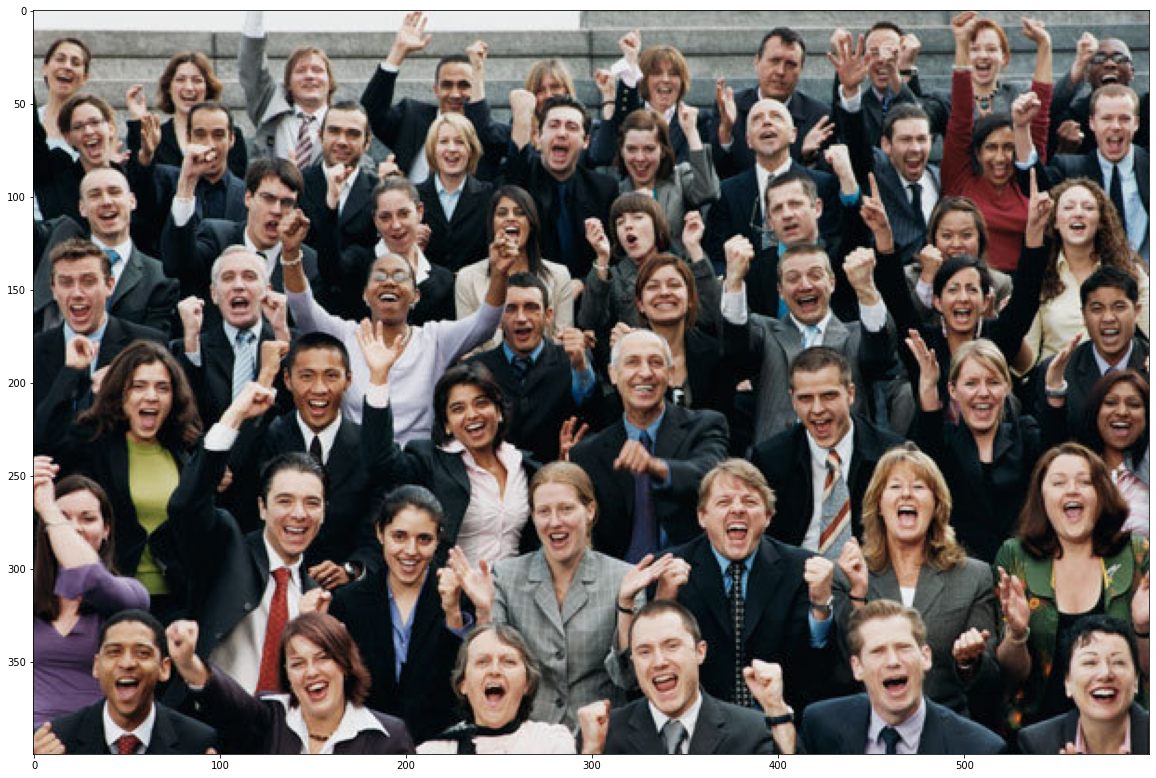

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))
plt.imshow(frame[:,:,::-1])

**Image preprocessing happens here**

In [63]:
scale = torch.Tensor([img.shape[1],img.shape[0],img.shape[1],img.shape[0]])
img -= (104,117,123)
img = img.transpose(2,0,1)
img = torch.from_numpy(img).unsqueeze(0)
img = img.to(device)
scale = scale.to(device)

# tic = time.time()
loc, conf, landms = net(img)
# print('net forward time: {:.4f}'.format(time.time() - tic))
scale

tensor([600., 400., 600., 400.], device='cuda:0')

In [64]:
priorbox = PriorBox(cfg, image_size=(im_height,im_width))
priors = priorbox.forward()
priors = priors.to(device)
prior_data = priors.data 
boxes = decode(loc.data.squeeze(0),prior_data,cfg['variance'])
boxes = boxes * scale / resize
boxes = boxes.cpu().numpy()
scores = conf.squeeze(0).data.cpu().numpy()[:,1]
landms = decode_landm(landms.data.squeeze(0),prior_data,cfg['variance'])
scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                      img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                      img.shape[3], img.shape[2]])
scale1 = scale1.to(device)
landms = landms * scale1 /resize
landms = landms.cpu().numpy()

# ignore low scores
# inds = np.where(scores > args.confidence_threshold)[0]
inds = np.where(scores > 0.05)[0]
boxes = boxes[inds]
landms = landms[inds]
scores = scores[inds]

In [65]:
# keep top-K before NMS
# order = scores.argsort()[::-1][:args.top_k]
order = scores.argsort()[::-1][:5000]
boxes = boxes[order]
landms = landms[order]
scores = scores[order]

# do NMS
dets = np.hstack((boxes,scores[:,np.newaxis])).astype(np.float32,copy=False)
# keep =py_cpu_nms(dets,args.nms_threshold)/
keep =py_cpu_nms(dets,0.3)
# keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
dets = dets[keep, :]
landms = landms[keep]

# keep top-K faster NMS
# dets = dets[:args.keep_top_k,:]
# landms = landms[:args.keep_top_k,:]
dets = dets[:750,:]
landms = landms[:750,:]

dets = np.concatenate((dets,landms),axis=1)

# show image
# if args.save_image:
dets

array([[572.5517  , 200.72334 , 597.2665  , ..., 222.98152 , 589.39294 ,
        223.92938 ],
       [187.82416 , 269.20062 , 216.59828 , ..., 296.14304 , 207.36456 ,
        297.98404 ],
       [138.03407 , 182.32631 , 167.99649 , ..., 210.33983 , 158.82056 ,
        210.47415 ],
       ...,
       [ 97.61557 ,  28.091251, 112.11609 , ...,  41.68273 , 107.33534 ,
         41.479477],
       [183.2533  ,  78.15308 , 197.16824 , ...,  91.400276, 192.78468 ,
         91.16577 ],
       [562.0325  ,  15.189272, 571.8083  , ...,  26.98527 , 568.1521  ,
         27.151207]], dtype=float32)

In [66]:
import matplotlib.pyplot as plt
for b in dets:
    # if b[4] < args.vis_thres:
    # here b[4] is of <class 'numpy.float32'>
    xx = b[4].item()
    if  xx < 0.6:
        continue
    text = "{:.4f}".format(b[4])
    b = list(map(int, b))
    cv2.rectangle(frame, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
    cx = b[0]
    cy = b[1] + 12
    cv2.putText(frame, text, (cx, cy),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

    # landms
    cv2.circle(frame, (b[5], b[6]), 4, (0, 0, 255), 4)
    cv2.circle(frame, (b[7], b[8]), 4, (0, 255, 255), 4)
    cv2.circle(frame, (b[9], b[10]), 4, (255, 0, 255), 4)
    cv2.circle(frame, (b[11], b[12]), 4, (0, 255, 0), 4)
    cv2.circle(frame, (b[13], b[14]), 4, (255, 0, 0), 4)

**Here you can see the output image**

True

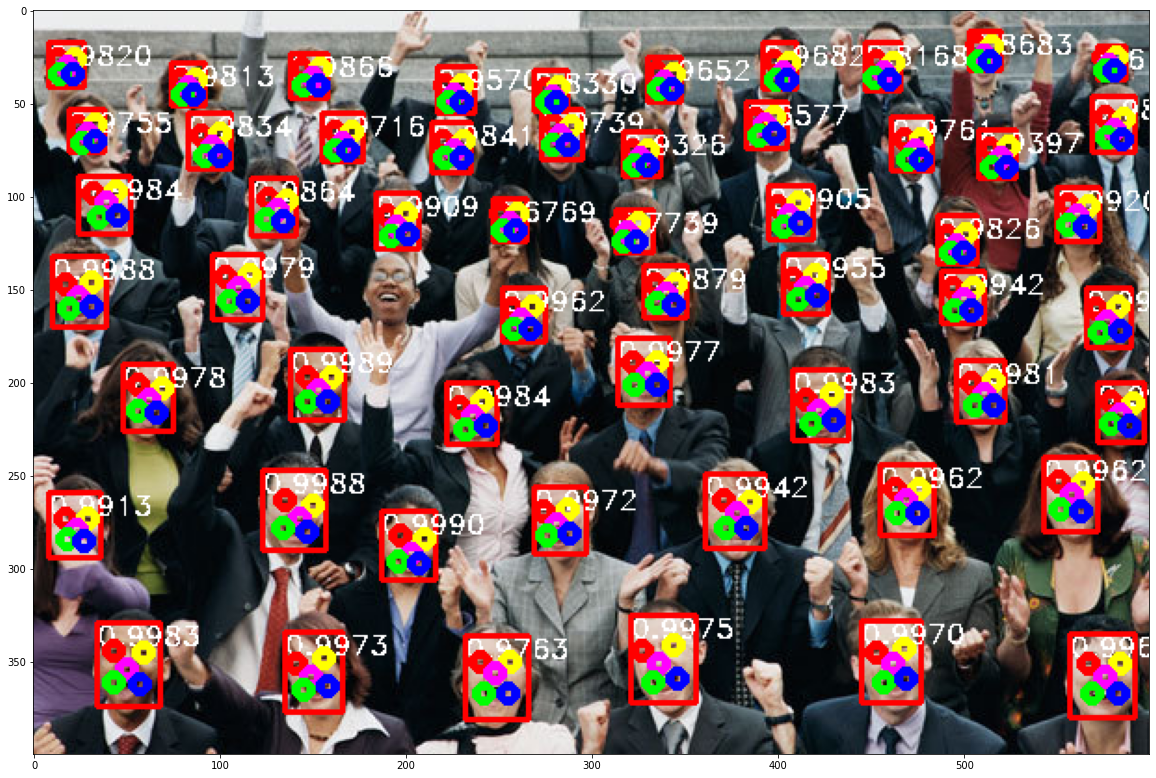

In [67]:
 # cv2.imshow("Capture",frame)
plt.figure(figsize = (20,20))
plt.imshow(frame[:,:,::-1])
cv2.imwrite(os.path.join(input_directory,str("o" + str(1) + '_' + '.jpg')),frame)